In [69]:
import pandas as pd
from preprocessing.light.text_cleaner_light import TextCleaner
from preprocessing.text_tokenizer import TextTokenizer
from preprocessing.light.text_lemmatizer_light import TextLemmatizer
from preprocessing.light.stopword_remover_light import StopwordRemover
import torch
import torch.nn as nn
from embedding.fasttext import FastText
import nltk
import os

from bs4 import MarkupResemblesLocatorWarning
import warnings

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

nltk_dir = 'nltk_data'
nltk.data.path.append(os.path.abspath(nltk_dir))

In [70]:
df = pd.read_csv('./data/chatgpt-reddit-comments.csv')

In [71]:
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [72]:
df_shortened = df.sample(n=1000)
# Keep only the comment_body column
df_shortened = df_shortened[['comment_body']]
df_shortened.head()

,comment_body
6068,Well no. The target audience for this is prima...
31043,"Honest question, how does ChatGPT help speed u..."
12138,You’re getting something out of it either way
10140,But that's my favorite kind of data
9119,Kurt Vonnegut already covered this in a short ...


In [73]:
TextCleaner = TextCleaner()
df_cleaned = df_shortened.copy()
for index, row in df_shortened.iterrows():
    df_cleaned.at[index, 'comment_body'] = TextCleaner.clean_text(row['comment_body'])

df_cleaned.head()

,comment_body
6068,well no the target audience for this is primar...
31043,honest question how does chatgpt help speed up...
12138,you’re getting something out of it either way
10140,but that's my favorite kind of data
9119,kurt vonnegut already covered this in a short ...


In [74]:
TextTokenizer = TextTokenizer()
df_tokenised = df_cleaned.copy()
for index, row in df_cleaned.iterrows():
    df_tokenised.at[index, 'comment_body'] = TextTokenizer.tokenize(row['comment_body'])

df_tokenised.head()

,comment_body
6068,"[well, no, the, target, audience, for, this, i..."
31043,"[honest, question, how, does, chatgpt, help, s..."
12138,"[you, ’, re, getting, something, out, of, it, ..."
10140,"[but, that, 's, my, favorite, kind, of, data]"
9119,"[kurt, vonnegut, already, covered, this, in, a..."


In [75]:
StopwordRemover = StopwordRemover()
df_stopwords_removed = df_tokenised.copy()
for index, row in df_tokenised.iterrows():
    df_stopwords_removed.at[index, 'comment_body'] = StopwordRemover.remove_stopwords(row['comment_body'])

df_stopwords_removed.head()

,comment_body
6068,"[well, no, target, audience, primarily, going,..."
31043,"[honest, question, chatgpt, help, speed, your,..."
12138,"[you, ’, getting, something, either, way]"
10140,"[but, 's, my, favorite, kind, data]"
9119,"[kurt, vonnegut, already, covered, short, stor..."


In [76]:
TextLemmatizer = TextLemmatizer()
df_lemmatised = df_stopwords_removed.copy()
for index, row in df_stopwords_removed.iterrows():
    df_lemmatised.at[index, 'comment_body'] = TextLemmatizer.lemmatize(row['comment_body'])

df_lemmatised.head()


,comment_body
6068,"[wel, no, target, audience, primarily, go, dev..."
31043,"[honest, question, chatgpt, help, speed, your,..."
12138,"[you, ’, get, something, either, way]"
10140,"[but, 's, my, favorite, kind, data]"
9119,"[kurt, vonegut, already, cover, short, story, ..."


In [77]:
# Check for empty comment bodies
empty_comments = df_lemmatised[df_lemmatised['comment_body'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")
	print(empty_comments.index.tolist())

# Remove empty comments
df_lemmatised = df_lemmatised[df_lemmatised['comment_body'].apply(lambda x: len(x) > 0)]

# Check for empty comment bodies again
empty_comments = df_lemmatised[df_lemmatised['comment_body'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")

Number of empty comments: 3

Empty comments found at indices:
[15888, 906, 8223]
Number of empty comments: 0


In [79]:
fasttext = FastText()
df_embeddings = df_lemmatised.copy()
for index, row in df_lemmatised.iterrows():
    df_embeddings.at[index, 'comment_body'] = fasttext.fit_transform(row['comment_body'])

df_embeddings.head()

,comment_body
6068,"[[-0.0015685549, -0.00063735497, 0.00025610105..."
31043,"[[-0.002523894, -0.00022260385, 0.0012745028, ..."
12138,"[[-0.0013823122, 0.0015027038, 0.004246538, -0..."
10140,"[[-0.0020843192, -0.00069697853, 0.0012438336,..."
9119,"[[-0.003093817, 0.00037026755, 0.0001215018, 0..."


In [86]:
# Corriger pour utiliser df_embeddings au lieu de df_shortened
embeddings_list = df_embeddings['comment_body'].tolist()
X_tensor = torch.stack([torch.tensor(emb[0], dtype=torch.float32) for emb in embeddings_list])

X_normalised = nn.functional.normalize(X_tensor, dim=1)

print("Forme du tenseur normalisé:", X_normalised.shape)
print("Type de données:", X_normalised.dtype)
print("Premiers embeddings normalisés:")
print(X_normalised[:5])

Forme du tenseur normalisé: torch.Size([997, 100])
Type de données: torch.float32
Premiers embeddings normalisés:
tensor([[-6.7944e-02, -2.7608e-02,  1.1093e-02, -1.9594e-02, -1.3366e-01,
         -6.7888e-02, -1.0984e-01, -2.0408e-03,  1.1035e-01,  5.1364e-02,
          3.9179e-02,  7.5048e-02,  9.5151e-02,  1.4180e-01, -5.0130e-02,
          6.6154e-02, -1.7204e-01,  2.0116e-02, -6.2170e-02, -1.4266e-01,
         -7.4383e-03,  1.4021e-01, -2.1901e-02,  3.3547e-02, -1.2465e-02,
         -1.5679e-02,  5.0775e-02,  1.4304e-01,  1.3047e-02, -1.7786e-02,
          5.9510e-02, -1.5878e-01, -1.2184e-01,  1.1432e-01,  9.8218e-02,
          1.4094e-01, -1.5542e-02, -1.7387e-01,  2.2408e-02,  8.1070e-02,
          1.2506e-01,  5.2415e-02,  1.2989e-01, -6.4423e-02, -1.0034e-01,
          1.1741e-01, -1.1465e-02, -7.1885e-03,  1.2384e-01, -1.3199e-01,
          6.8267e-02, -1.9015e-01, -2.9003e-03,  4.1004e-02, -3.6631e-02,
         -2.5901e-01,  4.2535e-02, -4.2231e-02, -1.2047e-01,  1.3133e-01

In [87]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        X_encoded = self.encoder(x)
        X_decoded = self.decoder(X_encoded)
        return X_decoded


In [88]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx]

print("Classes Dataset et DataLoader préparées")


Classes Dataset et DataLoader préparées


In [89]:
# Initialiser le modèle et les paramètres d'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")

# Créer l'autoencoder
input_dim = X_normalised.shape[1] 
hidden_dim = 32 
model = AutoEncoder(input_dim, hidden_dim).to(device)

# Déplacer les données vers le bon device
X_normalised = X_normalised.to(device)

# Créer le dataset et dataloader maintenant que X_normalised est prêt
dataset = EmbeddingDataset(X_normalised)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Modèle créé avec input_dim={input_dim}, hidden_dim={hidden_dim}")
print(f"Nombre de paramètres: {sum(p.numel() for p in model.parameters())}")
print(f"Dataset créé avec {len(dataset)} échantillons")
print(f"Nombre de batches: {len(dataloader)}")


Utilisation du device: cpu
Type des données: torch.float32
Type des paramètres du modèle: torch.float32
Modèle créé avec input_dim=100, hidden_dim=32
Nombre de paramètres: 6532
Dataset créé avec 997 échantillons
Nombre de batches: 32


In [ ]:
epochs = 100
train_losses = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch in dataloader:
        batch = batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    # Afficher la perte toutes les 10 époques
    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch+1}/{epochs}, Perte moyenne: {avg_loss:.6f}")

print("Entraînement terminé !")


Époque 10/100, Perte moyenne: 0.001910
Époque 20/100, Perte moyenne: 0.000959
Époque 30/100, Perte moyenne: 0.000688
Époque 40/100, Perte moyenne: 0.000579
Époque 50/100, Perte moyenne: 0.000528
Époque 60/100, Perte moyenne: 0.000534
Époque 70/100, Perte moyenne: 0.000498
Époque 80/100, Perte moyenne: 0.000478
Époque 90/100, Perte moyenne: 0.000469
Époque 100/100, Perte moyenne: 0.000481
Entraînement terminé !


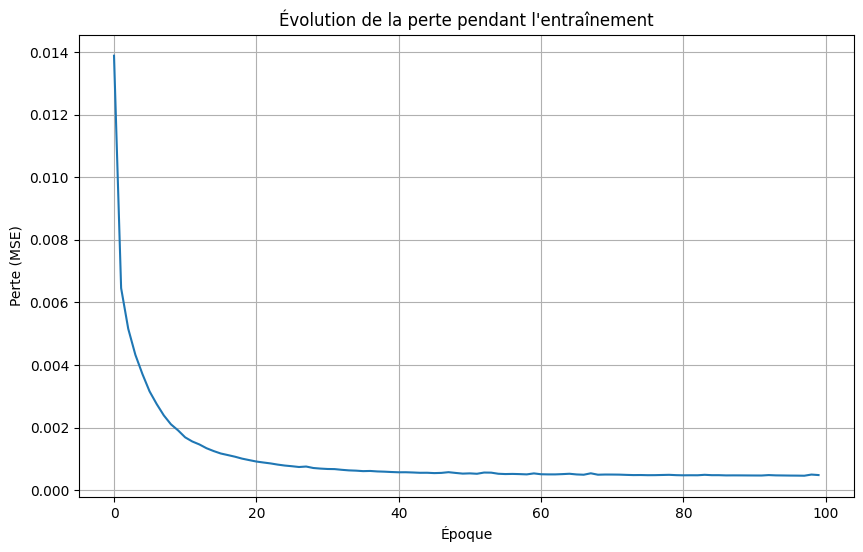

Perte finale: 0.000481


In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Évolution de la perte pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.grid(True)
plt.show()

print(f"Perte finale: {train_losses[-1]:.6f}")
